In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import psutil
import time
import GPUtil
import matplotlib.pyplot as plt

In [17]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/seg_train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"   
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/seg_test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int"   
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [19]:
def get_cpu_ram():
    cpu_percent = psutil.cpu_percent(interval=1)
    ram = psutil.virtual_memory()
    ram_used_mb = ram.used / (1024 ** 2)
    return cpu_percent, ram_used_mb
def get_gpu_stats():

    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return None, None, None
        gpu = gpus[0]
        return gpu.load * 100, gpu.memoryUsed, gpu.memoryTotal
    except:
        return None, None, None


In [20]:
cpu_before, ram_before = get_cpu_ram()
gpu_before, vram_used_before, vram_total_before = get_gpu_stats()

msg = f"AVANT entraînement → CPU: {cpu_before:.1f}% | RAM: {ram_before:.0f} MB"
if gpu_before is not None:
    msg += f" | GPU: {gpu_before:.1f}% | VRAM: {vram_used_before}/{vram_total_before} MB"
print(msg)


AVANT entraînement → CPU: 2.9% | RAM: 6379 MB | GPU: 1.0% | VRAM: 0.0/4096.0 MB


In [21]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  

In [22]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(6, activation="softmax")
])

In [23]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)


In [24]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

class PerformanceCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        cpu, ram = get_cpu_ram()
        gpu, vram_used, vram_total = get_gpu_stats()
        duration = time.time() - self.start_time

        msg = f" | CPU: {cpu:.1f}% | RAM: {ram:.0f} MB | Time: {duration:.1f}s"
        if gpu is not None:
            msg += f" | GPU: {gpu:.1f}% | VRAM: {vram_used}/{vram_total} MB"
        print(msg)



In [25]:
print("TensorFlow version:", tf.__version__)
print("GPUs disponibles :", tf.config.list_physical_devices("GPU"))

TensorFlow version: 2.10.1
GPUs disponibles : []


In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, PerformanceCallback()]
)


Epoch 1/10
439/439 [==============================] - 303s 683ms/step - loss: 0.7944 - accuracy: 0.6920 - val_loss: 0.6232 - val_accuracy: 0.7600
Epoch 2/10
439/439 [==============================] - 269s 612ms/step - loss: 0.6200 - accuracy: 0.7674 - val_loss: 0.5975 - val_accuracy: 0.7730
Epoch 3/10
439/439 [==============================] - 282s 643ms/step - loss: 0.5755 - accuracy: 0.7833 - val_loss: 0.5702 - val_accuracy: 0.7793
Epoch 4/10
439/439 [==============================] - 290s 660ms/step - loss: 0.5392 - accuracy: 0.7949 - val_loss: 0.5568 - val_accuracy: 0.7867
Epoch 5/10
439/439 [==============================] - 295s 671ms/step - loss: 0.5147 - accuracy: 0.8049 - val_loss: 0.5547 - val_accuracy: 0.7940
Epoch 6/10
439/439 [==============================] - 283s 645ms/step - loss: 0.4876 - accuracy: 0.8141 - val_loss: 0.5485 - val_accuracy: 0.7953
Epoch 7/10
439/439 [==============================] - 287s 654ms/step - loss: 0.4692 - accuracy: 0.8217 - val_loss: 0.5611 -

In [27]:
cpu_after, ram_after = get_cpu_ram()
gpu_after, vram_used_after, vram_total_after = get_gpu_stats()

msg = f"APRÈS entraînement → CPU: {cpu_after:.1f}% | RAM: {ram_after:.0f} MB"
if gpu_after is not None:
    msg += f" | GPU: {gpu_after:.1f}% | VRAM: {vram_used_after}/{vram_total_after} MB"
print(msg)


APRÈS entraînement → CPU: 8.6% | RAM: 6173 MB | GPU: 1.0% | VRAM: 0.0/4096.0 MB


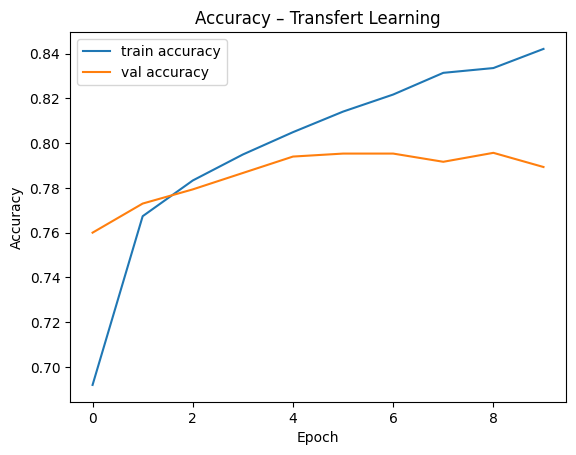

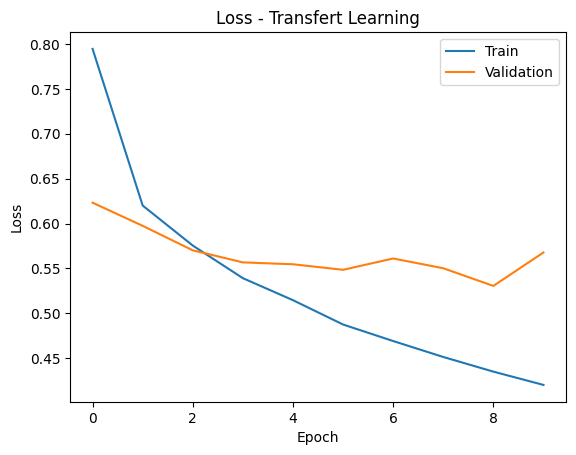

In [28]:
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy – Transfert Learning")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Loss - Transfert Learning")
plt.show()

### Conclusion 
Les courbes de loss et d’accuracy montrent une convergence stable du modèle au fil des epochs, avec une diminution régulière de la loss de validation et une augmentation progressive de l’accuracy. L’écart limité entre les performances d’entraînement et de validation indique une bonne généralisation, sans surapprentissage marqué, ce qui confirme l’efficacité du transfert learning sur ce jeu de données.

Le temps d’entraînement par epoch, bien que relativement élevé en raison de l’exécution sur CPU, reste stable, traduisant un pipeline maîtrisé. La matrice de confusion met en évidence des performances globalement satisfaisantes, avec des confusions principalement entre classes visuellement proches. Ces résultats confirment que le transfert learning offre un bon compromis entre performances et coût computationnel pour la classification d’images de scènes naturelles.